# Feature Scaling & Normalization with Heart Disease

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score


import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

C:\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.

In [2]:
df = pd.read_csv("heart.csv")
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


In [4]:
# Identify features/target
X = df.drop("target", axis=1)
y = df["target"]

In [5]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### 3: Define Preprocessing Functions

In [9]:
def preprocess_data(scaling=None, one_hot=False):
    """
    scaling: None | 'standard' | 'minmax'
    one_hot: bool (whether to one-hot encode categorical features)
    """
    X_train_prep, X_test_prep = X_train.copy(), X_test.copy()
    
    
    # Identify categorical features (these depend on dataset)
    categorical_features = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]
    numeric_features = [col for col in X_train.columns if col not in categorical_features]
    
    
    if one_hot:
        X_train_prep = pd.get_dummies(X_train_prep, columns=categorical_features, drop_first=True)
        X_test_prep = pd.get_dummies(X_test_prep, columns=categorical_features, drop_first=True)
        # Align columns (test may miss some)
        X_test_prep = X_test_prep.reindex(columns=X_train_prep.columns, fill_value=0)
    else:
        le = LabelEncoder()
        for col in categorical_features:
            X_train_prep[col] = le.fit_transform(X_train_prep[col])
            X_test_prep[col] = le.transform(X_test_prep[col])
            
    
    # Apply scaling
    if scaling == 'standard':
        scaler = StandardScaler()
        X_train_prep[numeric_features] = scaler.fit_transform(X_train_prep[numeric_features])
        X_test_prep[numeric_features] = scaler.transform(X_test_prep[numeric_features])
    elif scaling == 'minmax':
        scaler = MinMaxScaler()
        X_train_prep[numeric_features] = scaler.fit_transform(X_train_prep[numeric_features])
        X_test_prep[numeric_features] = scaler.transform(X_test_prep[numeric_features])
    
    
    return X_train_prep, X_test_prep

### 4: Define Neural Network

In [11]:
def build_model(input_dim, lr=0.001):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

In [12]:
def run_experiment(scaling=None, one_hot=False, lr=0.001, epochs=50):
    X_train_prep, X_test_prep = preprocess_data(scaling=scaling, one_hot=one_hot)
    
    
    model = build_model(X_train_prep.shape[1], lr=lr)
    history = model.fit(X_train_prep, y_train,
    validation_split=0.2,
    epochs=epochs,
    batch_size=32,
    verbose=0)
    
    
    # Evaluate
    y_pred = (model.predict(X_test_prep) > 0.5).astype(int)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    

    return history, acc, prec, rec

C:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Accuracy: 0.620, Precision: 0.708, Recall: 0.438


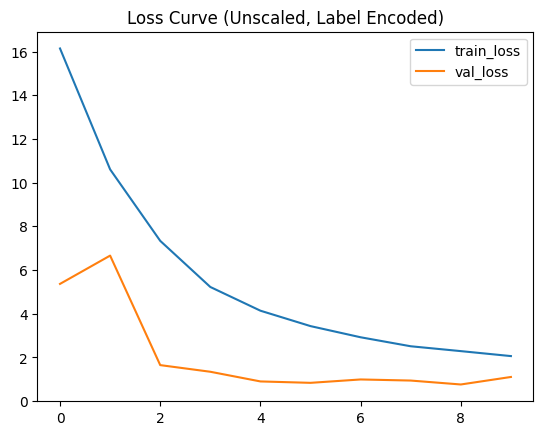

In [13]:
history, acc, prec, rec = run_experiment(scaling=None, one_hot=False, lr=0.001, epochs=10)


print(f"Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}")


# Plot training vs validation loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title("Loss Curve (Unscaled, Label Encoded)")
plt.show()

In [16]:
configs = [
(None, False),
(None, True),
('standard', False),
('standard', True),
('minmax', False),
('minmax', True)
]


results = []
for scaling, one_hot in configs:
    for lr in [0.01, 0.001, 0.0001]:
        history, acc, prec, rec = run_experiment(scaling=scaling, one_hot=one_hot, lr=lr, epochs=10)
        results.append({
        'scaling': scaling,
        'one_hot': one_hot,
        'lr': lr,
        'acc': acc,
        'prec': prec,
        'rec': rec,
        'final_val_loss': history.history['val_loss'][-1]
        })
    
    
    results_df = pd.DataFrame(results)
    print(results_df)

C:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


C:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


C:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
  scaling  one_hot      lr       acc      prec       rec  final_val_loss
0    None    False  0.0100  0.726829  0.692913  0.838095        0.571947
1    None    False  0.0010  0.643902  0.605263  0.876190        0.784496
2    None    False  0.0001  0.512195  0.512195  1.000000        2.897924


C:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


C:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


C:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
  scaling  one_hot      lr       acc      prec       rec  final_val_loss
0    None    False  0.0100  0.726829  0.692913  0.838095        0.571947
1    None    False  0.0010  0.643902  0.605263  0.876190        0.784496
2    None    False  0.0001  0.512195  0.512195  1.000000        2.897924
3    None     True  0.0100  0.702439  0.761905  0.609524        0.587920
4    None     True  0.0010  0.600000  0.564972  0.952381        0.881247
5    None     True  0.0001  0.531707  0.800000  0.114286        4.519476


C:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


C:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


C:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
    scaling  one_hot      lr       acc      prec       rec  final_val_loss
0      None    False  0.0100  0.726829  0.692913  0.838095        0.571947
1      None    False  0.0010  0.643902  0.605263  0.876190        0.784496
2      None    False  0.0001  0.512195  0.512195  1.000000        2.897924
3      None     True  0.0100  0.702439  0.761905  0.609524        0.587920
4      None     True  0.0010  0.600000  0.564972  0.952381        0.881247
5      None     True  0.0001  0.531707  0.800000  0.114286        4.519476
6  standard    False  0.0100  0.941463  0.951456  0.933333        0.257537
7  standard    False  0.0010  0.853659  0.826087  0.904762        0.423605
8  standard    False  0.0001  0.751220  0.690141  0.933333        0.619826


C:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


C:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


C:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
     scaling  one_hot      lr       acc      prec       rec  final_val_loss
0       None    False  0.0100  0.726829  0.692913  0.838095        0.571947
1       None    False  0.0010  0.643902  0.605263  0.876190        0.784496
2       None    False  0.0001  0.512195  0.512195  1.000000        2.897924
3       None     True  0.0100  0.702439  0.761905  0.609524        0.587920
4       None     True  0.0010  0.600000  0.564972  0.952381        0.881247
5       None     True  0.0001  0.531707  0.800000  0.114286        4.519476
6   standard    False  0.0100  0.941463  0.951456  0.933333        0.257537
7   standard    False  0.0010  0.853659  0.826087  0.904762        0.423605
8   standard    False  0.0001  0.751220  0.690141  0.933333        0.619826
9   standard     True  0.0100  0.960976  0.961905  0.961905        0.114946
10  standard     True  0.0010  0.858537  0.833333  0.904762        0.329464
11  standard     True  0.0001  0.746341  0.719008 

C:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


C:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


C:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
     scaling  one_hot      lr       acc      prec       rec  final_val_loss
0       None    False  0.0100  0.726829  0.692913  0.838095        0.571947
1       None    False  0.0010  0.643902  0.605263  0.876190        0.784496
2       None    False  0.0001  0.512195  0.512195  1.000000        2.897924
3       None     True  0.0100  0.702439  0.761905  0.609524        0.587920
4       None     True  0.0010  0.600000  0.564972  0.952381        0.881247
5       None     True  0.0001  0.531707  0.800000  0.114286        4.519476
6   standard    False  0.0100  0.941463  0.951456  0.933333        0.257537
7   standard    False  0.0010  0.853659  0.826087  0.904762        0.423605
8   standard    False  0.0001  0.751220  0.690141  0.933333        0.619826
9   standard     True  0.0100  0.960976  0.961905  0.961905        0.114946
10  standard     True  0.0010  0.858537  0.833333  0.904762        0.329464
11  standard     True  0.0001  0.746341  0.719008 

C:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


C:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


C:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
     scaling  one_hot      lr       acc      prec       rec  final_val_loss
0       None    False  0.0100  0.726829  0.692913  0.838095        0.571947
1       None    False  0.0010  0.643902  0.605263  0.876190        0.784496
2       None    False  0.0001  0.512195  0.512195  1.000000        2.897924
3       None     True  0.0100  0.702439  0.761905  0.609524        0.587920
4       None     True  0.0010  0.600000  0.564972  0.952381        0.881247
5       None     True  0.0001  0.531707  0.800000  0.114286        4.519476
6   standard    False  0.0100  0.941463  0.951456  0.933333        0.257537
7   standard    False  0.0010  0.853659  0.826087  0.904762        0.423605
8   standard    False  0.0001  0.751220  0.690141  0.933333        0.619826
9   standard     True  0.0100  0.960976  0.961905  0.961905        0.114946
10  standard     True  0.0010  0.858537  0.833333  0.904762        0.329464
11  standard     True  0.0001  0.746341  0.719008 

In [17]:
# Group by scaling method and take mean accuracy/precision/recall
summary = results_df.groupby(['scaling','one_hot']).mean(numeric_only=True)[['acc','prec','rec']]
print(summary)

                       acc      prec       rec
scaling  one_hot                              
minmax   False    0.840650  0.827122  0.873016
         True     0.873171  0.875615  0.876190
standard False    0.848780  0.822561  0.923810
         True     0.855285  0.838082  0.898413
